In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

spark = SparkSession.builder.appName("PartitionByDemo").getOrCreate()

data = [
    (3, "Charlie", "US", 150, "2024-01-03"),
    (1, "Alice", "US", 100, "2024-01-01"),
    (2, "Bob", "EU", 200, "2024-01-02")
]

columns = ["order_id", "customer", "region", "amount", "order_date"]

df = spark.createDataFrame(data, columns) \
          .withColumn("order_date", to_date("order_date"))

df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 18:34:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/16 18:34:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/16 18:34:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/16 18:34:49 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/16 18:34:49 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
                                                                                

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+





# 1️⃣ What `partitionBy` Does

* **PySpark `partitionBy` is a **storage-level optimization**, not SQL analytics.**
* It **creates separate folders for each unique value** of the column(s) you specify.
* Inside each folder, Spark writes files (micro-partitions).
* **Different from SQL `PARTITION BY`** which is used for **window functions** and does **not physically split data**.

### Conceptually:

```text
PartitionBy column 'order_date':

/data/orders_partitioned/
   order_date=2024-01-01/   <-- contains rows with 2024-01-01
   order_date=2024-01-02/   <-- contains rows with 2024-01-02
   order_date=2024-01-03/   <-- contains rows with 2024-01-03
```

Inside each folder, Spark will write **one or more files** (depending on number of partitions in the DataFrame).

✅ Advantages:

* Queries on `order_date` scan **only the needed folders** → faster
* Works for **CSV, JSON, Parquet**, but Parquet is most efficient

---

* CSV/JSON also support `partitionBy`, but reading many small CSV/JSON files is **slower**
* Parquet stores schema + is columnar → **fastest for analytics**

---

# 4️⃣ Does `partitionBy` create “more partitions”?

* **Yes, physically**: Each unique value becomes a folder.
* **Inside each folder**, Spark may create multiple **micro-partition files** based on **number of RDD partitions**.

```python
# Number of partitions in DataFrame
df.rdd.getNumPartitions()
```

* By default: 200 partitions in Spark
* After writing with partitionBy → files are split inside each folder according to **these partitions**

---

# 5️⃣ Key Difference from SQL `PARTITION BY`

| Feature | PySpark `partitionBy`                | SQL `PARTITION BY`                            |
| ------- | ------------------------------------ | --------------------------------------------- |
| Purpose | Physical storage / file organization | Window functions for analytics                |
| Output  | Multiple folders with data           | Does NOT change physical files                |
| Example | `/orders/order_date=2024-01-01/`     | `ROW_NUMBER() OVER (PARTITION BY order_date)` |

---

# 6️⃣ Example: Filter by Partition (Optimized)

```python
# Only read Jan 2, 2024
spark.read.parquet("/data/orders_partitioned_parquet/order_date=2024-01-02").show()
```

* Reads **one folder only**
* Very fast → avoids scanning entire dataset

---


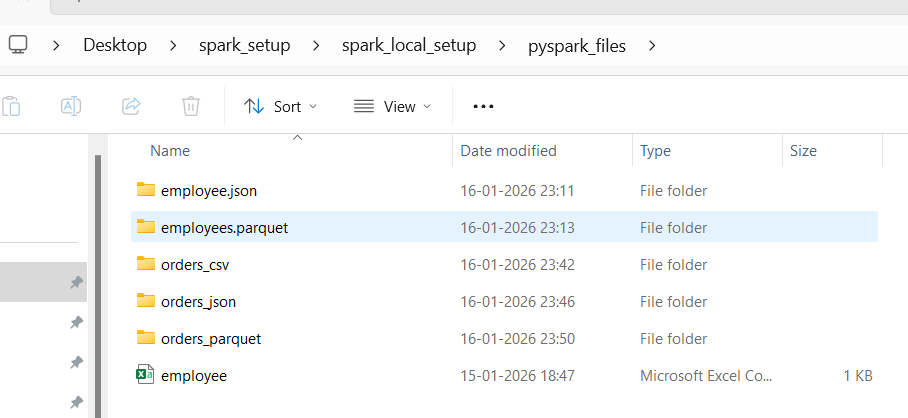

In [3]:
df.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



In [4]:
df.printSchema()

root
 |-- order_id: long (nullable = true)
 |-- customer: string (nullable = true)
 |-- region: string (nullable = true)
 |-- amount: long (nullable = true)
 |-- order_date: date (nullable = true)



In [6]:
df.write\
    .mode("overwrite")\
    .partitionBy("order_date")\
    .parquet("/data/orders_partitioned_parquet")

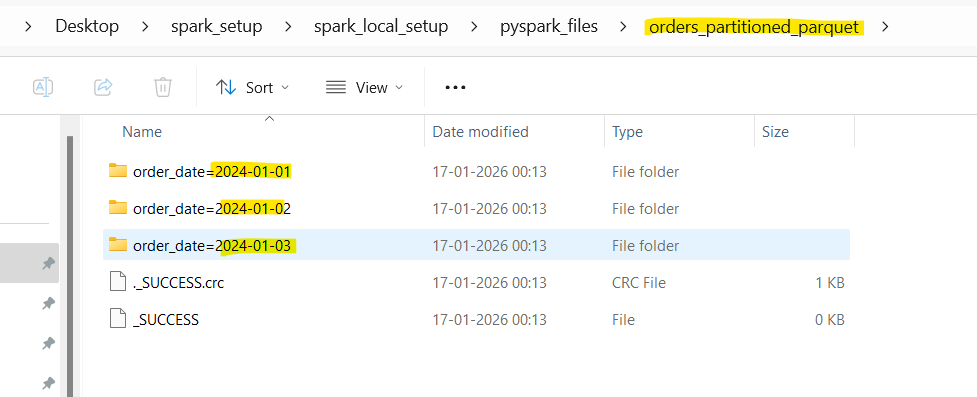

In [7]:
spark.read.parquet("/data/orders_partitioned_parquet").show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



In [8]:
spark.read.parquet("/data/orders_partitioned_parquet/order_date=2024-01-02").show()

+--------+--------+------+------+
|order_id|customer|region|amount|
+--------+--------+------+------+
|       2|     Bob|    EU|   200|
+--------+--------+------+------+



you are reading a partitioned Parquet folder directly:

/data/orders_partitioned_parquet/
    order_date=2024-01-01/
    order_date=2024-01-02/
    order_date=2024-01-03/


You are pointing Spark directly to the order_date=2024-01-02 folder. Spark treats this as just a regular Parquet file—it doesn’t automatically add the partition column (order_date) unless you read the root folder.

2️⃣ Why order_date is missing

In partitioned Parquet, partition columns are inferred only from the folder names if you read from the top-level directory.

By pointing directly to a partition folder, Spark thinks you’re reading a normal Parquet file. The folder name (order_date=2024-01-02) is not automatically turned into a column.

In [9]:
df = spark.read.parquet("/data/orders_partitioned_parquet")
df.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



In [10]:
df.filter(df.order_date == "2024-01-02").show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



Recommendation for production

Always read from the root folder for partitioned datasets.

Filter using the partition column to take advantage of partition pruning.

Only read a specific folder directly if you’re doing a one-off ad-hoc query and care about absolute minimal I/O.

In [11]:
df.write \
  .mode("overwrite") \
  .partitionBy("order_date") \
  .option("header", "true") \
  .csv("/data/orders_partitioned_csv")


In [14]:
spark.read.csv("/data/orders_partitioned_csv").show()

+--------+--------+------+------+----------+
|     _c0|     _c1|   _c2|   _c3|order_date|
+--------+--------+------+------+----------+
|order_id|customer|region|amount|2024-01-03|
|       3| Charlie|    US|   150|2024-01-03|
|order_id|customer|region|amount|2024-01-01|
|       1|   Alice|    US|   100|2024-01-01|
|order_id|customer|region|amount|2024-01-02|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



In [15]:
df.write \
  .mode("overwrite") \
  .partitionBy("order_date") \
  .json("/data/orders_partitioned_json")


In [17]:
spark.read.json("/data/orders_partitioned_json").show()

+------+--------+--------+------+----------+
|amount|customer|order_id|region|order_date|
+------+--------+--------+------+----------+
|   150| Charlie|       3|    US|2024-01-03|
|   100|   Alice|       1|    US|2024-01-01|
|   200|     Bob|       2|    EU|2024-01-02|
+------+--------+--------+------+----------+



Perfect! Let’s go **step by step** to understand how `partitionBy` works in PySpark **with CSV, JSON, and Parquet**, and how it differs from SQL `PARTITION BY`. I’ll also give **examples with your DataFrame**.

---

# 🔹 Base DataFrame

```python
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

spark = SparkSession.builder.appName("PartitionByDemo").getOrCreate()

data = [
    (3, "Charlie", "US", 150, "2024-01-03"),
    (1, "Alice", "US", 100, "2024-01-01"),
    (2, "Bob", "EU", 200, "2024-01-02")
]

columns = ["order_id", "customer", "region", "amount", "order_date"]

df = spark.createDataFrame(data, columns) \
          .withColumn("order_date", to_date("order_date"))

df.show()
```

```
+--------+--------+------+-------+----------+
|order_id|customer|region|amount |order_date|
+--------+--------+------+-------+----------+
|3       |Charlie |US    |150    |2024-01-03|
|1       |Alice   |US    |100    |2024-01-01|
|2       |Bob     |EU    |200    |2024-01-02|
+--------+--------+------+-------+----------+
```

---

# 1️⃣ What `partitionBy` Does

* **PySpark `partitionBy` is a **storage-level optimization**, not SQL analytics.**
* It **creates separate folders for each unique value** of the column(s) you specify.
* Inside each folder, Spark writes files (micro-partitions).
* **Different from SQL `PARTITION BY`** which is used for **window functions** and does **not physically split data**.

### Conceptually:

```text
PartitionBy column 'order_date':

/data/orders_partitioned/
   order_date=2024-01-01/   <-- contains rows with 2024-01-01
   order_date=2024-01-02/   <-- contains rows with 2024-01-02
   order_date=2024-01-03/   <-- contains rows with 2024-01-03
```

Inside each folder, Spark will write **one or more files** (depending on number of partitions in the DataFrame).

✅ Advantages:

* Queries on `order_date` scan **only the needed folders** → faster
* Works for **CSV, JSON, Parquet**, but Parquet is most efficient

---

# 2️⃣ PartitionBy with Parquet (Recommended)

```python
df.write \
  .mode("overwrite") \
  .partitionBy("order_date") \
  .parquet("/data/orders_partitioned_parquet")
```

### What happens:

Folder structure created:

```
/orders_partitioned_parquet/
   order_date=2024-01-01/
       part-00000.parquet
   order_date=2024-01-02/
       part-00000.parquet
   order_date=2024-01-03/
       part-00000.parquet
```

### Read data back

```python
spark.read.parquet("/data/orders_partitioned_parquet").show()
```

💡 Spark **automatically merges all partitions when reading** unless you filter by `order_date`.

---

# 3️⃣ PartitionBy with CSV / JSON

### CSV Example

```python
df.write \
  .mode("overwrite") \
  .partitionBy("order_date") \
  .option("header", "true") \
  .csv("/data/orders_partitioned_csv")
```

Folder structure:

```
/orders_partitioned_csv/
   order_date=2024-01-01/
       part-00000.csv
   order_date=2024-01-02/
       part-00000.csv
   order_date=2024-01-03/
       part-00000.csv
```

### JSON Example

```python
df.write \
  .mode("overwrite") \
  .partitionBy("order_date") \
  .json("/data/orders_partitioned_json")
```

Folder structure:

```
/orders_partitioned_json/
   order_date=2024-01-01/
       part-00000.json
   order_date=2024-01-02/
       part-00000.json
   order_date=2024-01-03/
       part-00000.json
```

✅ **Key points**

* CSV/JSON also support `partitionBy`, but reading many small CSV/JSON files is **slower**
* Parquet stores schema + is columnar → **fastest for analytics**

---

# 4️⃣ Does `partitionBy` create “more partitions”?

* **Yes, physically**: Each unique value becomes a folder.
* **Inside each folder**, Spark may create multiple **micro-partition files** based on **number of RDD partitions**.

```python
# Number of partitions in DataFrame
df.rdd.getNumPartitions()
```

* By default: 200 partitions in Spark
* After writing with partitionBy → files are split inside each folder according to **these partitions**

---

# 5️⃣ Key Difference from SQL `PARTITION BY`

| Feature | PySpark `partitionBy`                | SQL `PARTITION BY`                            |
| ------- | ------------------------------------ | --------------------------------------------- |
| Purpose | Physical storage / file organization | Window functions for analytics                |
| Output  | Multiple folders with data           | Does NOT change physical files                |
| Example | `/orders/order_date=2024-01-01/`     | `ROW_NUMBER() OVER (PARTITION BY order_date)` |

---

# 6️⃣ Example: Filter by Partition (Optimized)

```python
# Only read Jan 2, 2024
spark.read.parquet("/data/orders_partitioned_parquet/order_date=2024-01-02").show()
```

* Reads **one folder only**
* Very fast → avoids scanning entire dataset

---

# ✅ Summary (Layman Terms)

1. `partitionBy` **splits data physically** into folders
2. Works for **Parquet, CSV, JSON**, but **Parquet is faster & columnar**
3. Different from SQL `PARTITION BY` (storage vs window function)
4. Creates **micro-partitions (files)** inside each folder depending on DataFrame partitions
5. Optimizes queries for **filtering by partition column**

---

I can make a **diagram showing how CSV, JSON, Parquet partition physically** with micro-partitions inside folders. It’s super visual and makes this crystal clear.

Do you want me to make that diagram?
